In [56]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold


from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [57]:
def evaluate_regression_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    mae_train  = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))  
    r2_train   = r2_score(y_train, y_train_pred)

    mae_test  = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))      
    r2_test   = r2_score(y_test, y_test_pred)

    print(f"=== {name} ===")
    print(f"Train MAE : {mae_train:,.2f}")
    print(f"Train RMSE: {rmse_train:,.2f}")
    print(f"Train R2  : {r2_train:,.4f}")
    print("-" * 40)
    print(f"Test  MAE : {mae_test:,.2f}")
    print(f"Test  RMSE: {rmse_test:,.2f}")
    print(f"Test  R2  : {r2_test:,.4f}")
    
    return {
        "model": name,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "R2_train": r2_train,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "R2_test": r2_test,
    }

def evaluate_regression_model_real(name, model, X_train, X_test, y_train_log, y_test_log):
    # Fit trên log target
    model.fit(X_train, y_train_log)

    # Dự đoán trên log
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log  = model.predict(X_test)

    # Đưa về thang tiền gốc
    y_train_real      = np.expm1(y_train_log)
    y_test_real       = np.expm1(y_test_log)
    y_train_pred_real = np.expm1(y_train_pred_log)
    y_test_pred_real  = np.expm1(y_test_pred_log)

    # Metric trên thang tiền gốc
    mae_train  = mean_absolute_error(y_train_real, y_train_pred_real)
    rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred_real))
    r2_train   = r2_score(y_train_real, y_train_pred_real)

    mae_test  = mean_absolute_error(y_test_real, y_test_pred_real)
    rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred_real))
    r2_test   = r2_score(y_test_real, y_test_pred_real)

    print(f"=== {name} (evaluate on REAL PRICE) ===")
    print(f"Train MAE : {mae_train:,.2f}")
    print(f"Train RMSE: {rmse_train:,.2f}")
    print(f"Train R2  : {r2_train:,.4f}")
    print("-" * 40)
    print(f"Test  MAE : {mae_test:,.2f}")
    print(f"Test  RMSE: {rmse_test:,.2f}")
    print(f"Test  R2  : {r2_test:,.4f}")
    
    return {
        "model": name,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "R2_train": r2_train,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "R2_test": r2_test,
    }


In [58]:
df = pd.read_excel("rolling_sale_data.xlsx")
print("Kích thước ban đầu:", df.shape)

Kích thước ban đầu: (79884, 21)


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79884 entries, 0 to 79883
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         79884 non-null  int64         
 1   NEIGHBORHOOD                    79884 non-null  object        
 2   BUILDING CLASS CATEGORY         79884 non-null  object        
 3   TAX CLASS AT PRESENT            79884 non-null  object        
 4   BLOCK                           79884 non-null  int64         
 5   LOT                             79884 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       79884 non-null  object        
 8   ADDRESS                         79884 non-null  object        
 9   APARTMENT NUMBER                19539 non-null  object        
 10  ZIP CODE                        79863 non-null  float64       
 11  RE

In [60]:
# Lọc bỏ R* (CONDOMINIUM RENTALS)
mask_R  = df["BUILDING CLASS AT TIME OF SALE"].astype(str).str.startswith("R")
raw_data = df[~mask_R].copy()
print("Sau khi bỏ R*:", raw_data.shape)
raw_data["BUILDING CLASS AT TIME OF SALE"].value_counts().head()

# Lọc bỏ coop
coop_classes = ["D4", "D0", "C6", "C8", "A8", "CC", "DC", "H7"]
mask_coop = raw_data["BUILDING CLASS AT TIME OF SALE"].astype(str).isin(coop_classes)
raw_data = raw_data[~mask_coop].copy()
print("Sau khi bỏ coop:", raw_data.shape)
raw_data["BUILDING CLASS AT TIME OF SALE"].value_counts().head()

# Lọc bỏ SALE PRICE = 0
raw_data = raw_data[raw_data["SALE PRICE"] > 0].copy()
print("Sau khi bỏ Sale Price = 0:", raw_data.shape)

Sau khi bỏ R*: (58816, 21)
Sau khi bỏ coop: (43072, 21)
Sau khi bỏ Sale Price = 0: (24339, 21)


## RAW

In [61]:
target_col = "SALE PRICE"

# === 0. Thêm biến thời gian từ SALE DATE ===
raw_data["SALE_YM"] = raw_data["SALE DATE"].dt.to_period("M").astype(str)   # dùng để split theo thời gian

raw_features = [
    "BOROUGH",
    "NEIGHBORHOOD",
    "BUILDING CLASS CATEGORY",
    "TAX CLASS AT PRESENT",
    "BLOCK",
    "LOT",
    "BUILDING CLASS AT PRESENT",
    "ZIP CODE",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "TOTAL UNITS",
    "LAND SQUARE FEET",
    "GROSS SQUARE FEET",
    "YEAR BUILT",
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS AT TIME OF SALE",
]

# DataFrame cho kịch bản RAW
df_raw_scenario = raw_data[raw_features + [target_col, "SALE_YM"]].copy()

# === 1. Tách X, y (X chứa toàn bộ feature, chưa chia num/cat) ===
X_raw_full = df_raw_scenario.drop(columns=[target_col, "SALE_YM"])
y_raw      = df_raw_scenario[target_col]

# === 2. Xác định cột categorical / numeric ===
# Có thể chỉnh list này sau nếu muốn thêm/bớt cột category
cat_cols_raw = [
    "NEIGHBORHOOD",
    "BUILDING CLASS CATEGORY",
    "TAX CLASS AT PRESENT",
    "BUILDING CLASS AT PRESENT",
    "BUILDING CLASS AT TIME OF SALE",
]

# Giữ lại những cột cat thực sự có trong X_raw_full (tránh lỗi khi thiếu cột)
cat_cols_raw = [c for c in cat_cols_raw if c in X_raw_full.columns]

# Numeric = tất cả các cột còn lại
numeric_cols_raw = [c for c in X_raw_full.columns if c not in cat_cols_raw]

# Ép string cho categorical
for c in cat_cols_raw:
    X_raw_full[c] = X_raw_full[c].astype(str)

# === 3. Chia train/test theo 9 tháng đầu tiên (SALE_YM) ===
months_sorted = np.sort(df_raw_scenario["SALE_YM"].unique())
print("Các tháng (YEAR-MONTH) trong dữ liệu:", months_sorted)

train_months = months_sorted[:9]   # 9 tháng đầu của data
test_months  = months_sorted[9:]   # các tháng sau

train_mask = df_raw_scenario["SALE_YM"].isin(train_months)
test_mask  = df_raw_scenario["SALE_YM"].isin(test_months)

X_raw_train = X_raw_full[train_mask].copy()
X_raw_test  = X_raw_full[test_mask].copy()
y_raw_train = y_raw[train_mask].copy()
y_raw_test  = y_raw[test_mask].copy()

print("RAW train:", X_raw_train.shape, "RAW test:", X_raw_test.shape)

# === 4. PREPROCESSOR CHO RAW ===
numeric_transformer_raw = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer_raw = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocess_raw = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_raw, numeric_cols_raw),
        ("cat", categorical_transformer_raw, cat_cols_raw),
    ],
    remainder="drop"   # cột nào không liệt kê ở trên sẽ bị drop
)   

Các tháng (YEAR-MONTH) trong dữ liệu: ['2024-11' '2024-12' '2025-01' '2025-02' '2025-03' '2025-04' '2025-05'
 '2025-06' '2025-07' '2025-08' '2025-09' '2025-10']
RAW train: (18883, 16) RAW test: (5456, 16)


In [62]:
dt_raw = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,          
)

dt_pipe_raw = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("model", dt_raw),
])

results_dt_raw = evaluate_regression_model(
    name="DecisionTree_RAW_baseline_reg",
    model=dt_pipe_raw,
    X_train=X_raw_train,
    X_test=X_raw_test,
    y_train=y_raw_train,
    y_test=y_raw_test,
)

results_dt_raw

=== DecisionTree_RAW_baseline_reg ===
Train MAE : 737,021.27
Train RMSE: 1,978,660.21
Train R2  : 0.9293
----------------------------------------
Test  MAE : 2,260,820.67
Test  RMSE: 29,250,023.13
Test  R2  : 0.0348


{'model': 'DecisionTree_RAW_baseline_reg',
 'MAE_train': 737021.2672892386,
 'RMSE_train': np.float64(1978660.2058898506),
 'R2_train': 0.9293017333199508,
 'MAE_test': 2260820.670726568,
 'RMSE_test': np.float64(29250023.13209362),
 'R2_test': 0.0348309353887678}

In [63]:
# 2. Feature importance (sau khi model đã fit trong evaluate_regression_model)
pre_raw   = dt_pipe_raw.named_steps["preprocess"]
tree_raw  = dt_pipe_raw.named_steps["model"]

importances_raw = tree_raw.feature_importances_
n_importances_raw = len(importances_raw)

# tên feature sau preprocess (theo thiết kế ban đầu)
num_features_raw = list(pre_raw.transformers_[0][2])          # cột numeric gốc
cat_features_raw = list(pre_raw.transformers_[1][2])          # cột cat gốc

ohe_raw = pre_raw.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names_raw = list(ohe_raw.get_feature_names_out(cat_features_raw))

all_feature_names_raw = num_features_raw + cat_feature_names_raw

# Nếu số tên feature ≠ số importance thì xử lý cho khớp
if len(all_feature_names_raw) < n_importances_raw:
    # có thêm feature (vd. từ remainder hoặc selector) → đặt tên generic
    extra = [f"remainder_{i}" for i in range(n_importances_raw - len(all_feature_names_raw))]
    all_feature_names_raw = all_feature_names_raw + extra
elif len(all_feature_names_raw) > n_importances_raw:
    # thừa tên so với số importance → cắt bớt cho khớp
    all_feature_names_raw = all_feature_names_raw[:n_importances_raw]

print("Số feature name:", len(all_feature_names_raw))
print("Số importance :", n_importances_raw)

fi_raw_detail = pd.DataFrame({
    "feature": all_feature_names_raw,
    "importance": importances_raw,
}).sort_values("importance", ascending=False)

# Group theo feature gốc (NEIGHBORHOOD, ZIP CODE, ...)
fi_raw_group = fi_raw_detail.copy()
fi_raw_group["base_feature"] = fi_raw_group["feature"].str.split("__").str[0]
fi_raw_group = (
    fi_raw_group.groupby("base_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

print("\nTop 15 feature quan trọng (theo feature gốc) – RAW baseline:")
print(fi_raw_group.head(15))


Số feature name: 515
Số importance : 515

Top 15 feature quan trọng (theo feature gốc) – RAW baseline:
                                      base_feature  importance
254                              GROSS SQUARE FEET    0.359010
0                                            BLOCK    0.121486
514                                       ZIP CODE    0.115810
255                               LAND SQUARE FEET    0.066034
358         NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL    0.046298
512                                    TOTAL UNITS    0.034573
504                              RESIDENTIAL UNITS    0.030818
323                     NEIGHBORHOOD_EAST NEW YORK    0.023363
253                               COMMERCIAL UNITS    0.020407
513                                     YEAR BUILT    0.016722
404                      NEIGHBORHOOD_MIDTOWN EAST    0.012130
160              BUILDING CLASS AT TIME OF SALE_G6    0.012044
241  BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES    0.011804
510            

## STAGE 1: Feature Selection 

In [64]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# =========================
# CHẶNG 1: FEATURE SET MỚI
# =========================

target_col = "SALE PRICE"

raw_data["SALE DATE"] = pd.to_datetime(raw_data["SALE DATE"], errors="coerce")
raw_data["SALE_YM"] = raw_data["SALE DATE"].dt.to_period("M").astype(str)
raw_data.loc[28212, "ZIP CODE"] = 10305
raw_data.loc[28535, "ZIP CODE"] = 10308
raw_data.loc[30327, "ZIP CODE"] = 10309
raw_data.loc[78058, "ZIP CODE"] = 11356
raw_data.loc[78399, "ZIP CODE"] = 11415

# 1. Chọn bộ feature mới cho kịch bản RAW – CHẶNG 1
#    (SALE PRICE là target, SALE DATE chỉ dùng để tạo SALE_YM)
raw_features_stage1 = [
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "LAND SQUARE FEET",
    "GROSS SQUARE FEET",
    "YEAR BUILT",
    "TAX CLASS AT TIME OF SALE",
]

# DataFrame cho kịch bản RAW – CHẶNG 1
df_raw_stage1 = raw_data[raw_features_stage1 + [target_col, "SALE_YM"]].copy()

# 2. Tách X, y
X_raw_full_stage1 = df_raw_stage1.drop(columns=[target_col, "SALE_YM"])
y_raw_stage1      = df_raw_stage1[target_col]

# 3. Xác định cột categorical / numeric
cat_cols_raw_stage1 = [
    "BUILDING CLASS CATEGORY",
]

# Giữ lại những cột cat thực sự có trong X (phòng trường hợp thiếu)
cat_cols_raw_stage1 = [c for c in cat_cols_raw_stage1 if c in X_raw_full_stage1.columns]

# Numeric = tất cả các cột còn lại
numeric_cols_raw_stage1 = [c for c in X_raw_full_stage1.columns if c not in cat_cols_raw_stage1]

# Ép string cho categorical
for c in cat_cols_raw_stage1:
    X_raw_full_stage1[c] = X_raw_full_stage1[c].astype(str)

# 4. Chia train/test theo 9 tháng đầu tiên
months_sorted = np.sort(df_raw_stage1["SALE_YM"].unique())
print("Các tháng (YEAR-MONTH) trong dữ liệu:", months_sorted)

train_months = months_sorted[:9]   # 9 tháng đầu của data
test_months  = months_sorted[9:]   # các tháng sau

train_mask = df_raw_stage1["SALE_YM"].isin(train_months)
test_mask  = df_raw_stage1["SALE_YM"].isin(test_months)

X_raw_train_stage1 = X_raw_full_stage1[train_mask].copy()
X_raw_test_stage1  = X_raw_full_stage1[test_mask].copy()
y_raw_train_stage1 = y_raw_stage1[train_mask].copy()
y_raw_test_stage1  = y_raw_stage1[test_mask].copy()

print("RAW – CHẶNG 1  train:", X_raw_train_stage1.shape, "test:", X_raw_test_stage1.shape)

# 5. PREPROCESSOR CHO RAW – CHẶNG 1
numeric_transformer_raw_stage1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

categorical_transformer_raw_stage1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocess_raw_stage1 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_raw_stage1, numeric_cols_raw_stage1),
        ("cat", categorical_transformer_raw_stage1, cat_cols_raw_stage1),
    ],
    remainder="drop"
)

Các tháng (YEAR-MONTH) trong dữ liệu: ['2024-11' '2024-12' '2025-01' '2025-02' '2025-03' '2025-04' '2025-05'
 '2025-06' '2025-07' '2025-08' '2025-09' '2025-10']
RAW – CHẶNG 1  train: (18883, 8) test: (5456, 8)


In [65]:
dt_stage1 = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,          
)

dt_pipe_stage1 = Pipeline(steps=[
    ("preprocess", preprocess_raw_stage1),
    ("model", dt_stage1),
])

results_dt_stage1_2 = evaluate_regression_model(
    name="DecisionTree_RAW_Stage1",
    model=dt_pipe_stage1,
    X_train=X_raw_train_stage1,
    X_test=X_raw_test_stage1,
    y_train=y_raw_train_stage1,
    y_test=y_raw_test_stage1,
)

print("\nKết quả RAW Stage 1:", results_dt_stage1_2)

=== DecisionTree_RAW_Stage1 ===
Train MAE : 722,544.58
Train RMSE: 2,007,053.93
Train R2  : 0.9273
----------------------------------------
Test  MAE : 2,171,367.56
Test  RMSE: 28,361,767.42
Test  R2  : 0.0926

Kết quả RAW Stage 1: {'model': 'DecisionTree_RAW_Stage1', 'MAE_train': 722544.5759103055, 'RMSE_train': np.float64(2007053.9311650381), 'R2_train': 0.927258138230993, 'MAE_test': 2171367.5612619435, 'RMSE_test': np.float64(28361767.422689654), 'R2_test': 0.09256077442945321}


In [66]:
# 1. Lấy preprocess và model từ pipeline
pre_s1  = dt_pipe_stage1.named_steps["preprocess"]
tree_s1 = dt_pipe_stage1.named_steps["model"]

# 2. Lấy vector feature_importances_
importances_s1 = tree_s1.feature_importances_
n_importances_s1 = len(importances_s1)

# 3. Lấy tên feature sau preprocessing
#    (numeric giữ tên gốc, categorical qua OneHotEncoder)
num_features_s1 = list(pre_s1.transformers_[0][2])   # cột numeric gốc
cat_features_s1 = list(pre_s1.transformers_[1][2])   # cột categorical gốc

ohe_s1 = pre_s1.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names_s1 = list(ohe_s1.get_feature_names_out(cat_features_s1))

all_feature_names_s1 = num_features_s1 + cat_feature_names_s1

# 4. Đảm bảo số tên feature = số importance
if len(all_feature_names_s1) < n_importances_s1:
    # có thêm feature (vd. từ remainder/selector) → đặt tên generic
    extra = [f"remainder_{i}" for i in range(n_importances_s1 - len(all_feature_names_s1))]
    all_feature_names_s1 = all_feature_names_s1 + extra
elif len(all_feature_names_s1) > n_importances_s1:
    # thừa tên → cắt bớt cho khớp
    all_feature_names_s1 = all_feature_names_s1[:n_importances_s1]

print("Số feature name:", len(all_feature_names_s1))
print("Số importance :", n_importances_s1)

# 5. Bảng chi tiết importance theo feature sau OHE
fi_s1_detail = pd.DataFrame({
    "feature": all_feature_names_s1,
    "importance": importances_s1,
}).sort_values("importance", ascending=False)

print("\nTop 20 feature sau OHE – STAGE 1:")
display(fi_s1_detail.head(20))

# 6. Group lại theo feature gốc (BUILDING CLASS CATEGORY, ZIP CODE, ...)
fi_s1_group = fi_s1_detail.copy()
fi_s1_group["base_feature"] = fi_s1_group["feature"].str.split("__").str[0]

fi_s1_group = (
    fi_s1_group
    .groupby("base_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

print("\nTop 15 feature quan trọng (theo feature gốc) – STAGE 1:")
display(fi_s1_group.head(15))


Số feature name: 31
Số importance : 31

Top 20 feature sau OHE – STAGE 1:


,feature,importance
4,GROSS SQUARE FEET,4.491484e-01
0,ZIP CODE,1.461103e-01
3,LAND SQUARE FEET,1.277053e-01
1,RESIDENTIAL UNITS,1.092946e-01
5,YEAR BUILT,1.006392e-01
2,COMMERCIAL UNITS,1.884193e-02
19,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,1.275831e-02
6,TAX CLASS AT TIME OF SALE,9.590891e-03
30,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,8.180493e-03
14,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,5.441319e-03



Top 15 feature quan trọng (theo feature gốc) – STAGE 1:


,base_feature,importance
25,GROSS SQUARE FEET,0.449148
30,ZIP CODE,0.146110
26,LAND SQUARE FEET,0.127705
27,RESIDENTIAL UNITS,0.109295
29,YEAR BUILT,0.100639
24,COMMERCIAL UNITS,0.018842
12,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,0.012758
28,TAX CLASS AT TIME OF SALE,0.009591
23,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,0.008180
7,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,0.005441


## STAGE 3: REMOVE OUTLIER


In [67]:
import numpy as np

# =========================================
# STAGE 3 – OUTLIER FILTER SAU TRAIN/TEST
# =========================================

# Bắt đầu từ dữ liệu đã split của CHẶNG 1
X_raw_train_stage3 = X_raw_train_stage1.copy()
y_raw_train_stage3 = y_raw_train_stage1.copy()
X_raw_test_stage3  = X_raw_test_stage1.copy()
y_raw_test_stage3  = y_raw_test_stage1.copy()

print("Stage 3 (ban đầu) – train:", X_raw_train_stage3.shape, "test:", X_raw_test_stage3.shape)

# 1. BỎ CÁC GIAO DỊCH SALE PRICE QUÁ THẤP (không phải real sale)
#    (ngưỡng này là constant nên không vấn đề leakage)
mask_train_price = y_raw_train_stage3 > 1000
mask_test_price  = y_raw_test_stage3 > 1000

X_raw_train_stage3 = X_raw_train_stage3[mask_train_price].copy()
y_raw_train_stage3 = y_raw_train_stage3[mask_train_price].copy()

X_raw_test_stage3  = X_raw_test_stage3[mask_test_price].copy()
y_raw_test_stage3  = y_raw_test_stage3[mask_test_price].copy()

print("Sau khi bỏ SALE PRICE <= 1000 – train:", X_raw_train_stage3.shape, "test:", X_raw_test_stage3.shape)

# 2. HỌC NGƯỠNG PPSF TỪ TRAIN RỒI ÁP DỤNG CHO CẢ TRAIN + TEST
def compute_ppsf(X, y, eps=1e-6):
    # Diện tích hữu ích: ưu tiên GROSS, nếu =0 thì dùng LAND
    sqft = np.where(
        X["GROSS SQUARE FEET"] > 0,
        X["GROSS SQUARE FEET"],
        X["LAND SQUARE FEET"],
    )
    return y / np.maximum(sqft, eps)

# PPSF train để tính quantile
train_ppsf = compute_ppsf(X_raw_train_stage3, y_raw_train_stage3)

q_low, q_high = train_ppsf.quantile([0.01, 0.99])  # có thể chỉnh 0.005–0.995
print("Ngưỡng PPSF trên TRAIN (1%–99%):", q_low, q_high)

# Filter train theo PPSF
train_ppsf_mask = train_ppsf.between(q_low, q_high)
X_raw_train_stage3 = X_raw_train_stage3[train_ppsf_mask].copy()
y_raw_train_stage3 = y_raw_train_stage3[train_ppsf_mask].copy()

print("Sau khi cắt PPSF – train:", X_raw_train_stage3.shape)
print("Test giữ nguyên – test:", X_raw_test_stage3.shape)

# 3. ĐỊNH NGHĨA LẠI CAT / NUM CHO STAGE 3 (giống Stage 1 để model dễ so sánh)
cat_cols_raw_stage3 = [
    "BUILDING CLASS CATEGORY",
]
cat_cols_raw_stage3 = [c for c in cat_cols_raw_stage3 if c in X_raw_train_stage3.columns]

numeric_cols_raw_stage3 = [c for c in X_raw_train_stage3.columns if c not in cat_cols_raw_stage3]

for c in cat_cols_raw_stage3:
    X_raw_train_stage3[c] = X_raw_train_stage3[c].astype(str)
    X_raw_test_stage3[c]  = X_raw_test_stage3[c].astype(str)

# Preprocessor cho Stage 3 
numeric_transformer_raw_stage3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

categorical_transformer_raw_stage3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocess_raw_stage3 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_raw_stage3, numeric_cols_raw_stage3),
        ("cat", categorical_transformer_raw_stage3, cat_cols_raw_stage3),
    ],
    remainder="drop",
)

print("Numeric cols Stage 3:", numeric_cols_raw_stage3)
print("Categorical cols Stage 3:", cat_cols_raw_stage3)


Stage 3 (ban đầu) – train: (18883, 8) test: (5456, 8)
Sau khi bỏ SALE PRICE <= 1000 – train: (17824, 8) test: (5238, 8)
Ngưỡng PPSF trên TRAIN (1%–99%): 7.841162771410742 2815.215760015539
Sau khi cắt PPSF – train: (17466, 8)
Test giữ nguyên – test: (5238, 8)
Numeric cols Stage 3: ['ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']
Categorical cols Stage 3: ['BUILDING CLASS CATEGORY']


In [68]:
dt_stage3 = DecisionTreeRegressor(random_state=42, max_depth=10 )

dt_pipe_stage3 = Pipeline(steps=[
    ("preprocess", preprocess_raw_stage3),
    ("model", dt_stage3),
])

results_dt_stage3 = evaluate_regression_model(
    name="DecisionTree_RAW_Stage3",
    model=dt_pipe_stage3,
    X_train=X_raw_train_stage3,
    X_test=X_raw_test_stage3,
    y_train=y_raw_train_stage3,
    y_test=y_raw_test_stage3,
)

results_dt_stage3


=== DecisionTree_RAW_Stage3 ===
Train MAE : 536,833.89
Train RMSE: 1,206,985.23
Train R2  : 0.9689
----------------------------------------
Test  MAE : 2,021,973.54
Test  RMSE: 25,915,556.47
Test  R2  : 0.2723


{'model': 'DecisionTree_RAW_Stage3',
 'MAE_train': 536833.8947089027,
 'RMSE_train': np.float64(1206985.226083296),
 'R2_train': 0.9689386041988763,
 'MAE_test': 2021973.5377778374,
 'RMSE_test': np.float64(25915556.47261329),
 'R2_test': 0.272307762668621}

## STAGE 4: Chuẩn Hóa CATE

In [69]:
# =========================================
# STAGE 4 – CHUẨN HOÁ CATEGORICAL → STRING
# =========================================

# Dùng dữ liệu đã lọc outlier Stage 3
X_train_s4 = X_raw_train_stage3.copy()
y_train_s4 = y_raw_train_stage3.copy()

X_test_s4  = X_raw_test_stage3.copy()     # test vẫn giữ nguyên
y_test_s4  = y_raw_test_stage3.copy()

print("Stage 4 – input train:", X_train_s4.shape, "test:", X_test_s4.shape)

# ---------------------------------------------------
# 1. Xác định lại categorical columns
# ---------------------------------------------------
# Các biến cate THẬT SỰ trong bộ Stage 1/2/3:
cat_cols_s4 = [
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
    "TAX CLASS AT TIME OF SALE",
]

# Giữ lại cột nào thực sự tồn tại
cat_cols_s4 = [c for c in cat_cols_s4 if c in X_train_s4.columns]

# Các biến còn lại → numeric
numeric_cols_s4 = [c for c in X_train_s4.columns if c not in cat_cols_s4]

# ---------------------------------------------------
# 2. Ép toàn bộ CATEGORICAL → string
# ---------------------------------------------------
for c in cat_cols_s4:
    X_train_s4[c] = X_train_s4[c].astype(str)
    X_test_s4[c]  = X_test_s4[c].astype(str)

print("Categorical cols Stage 4:", cat_cols_s4)
print("Numeric cols Stage 4:", numeric_cols_s4)

# ---------------------------------------------------
# 3. Tạo PREPROCESSOR mới cho Stage 4
# ---------------------------------------------------
numeric_transformer_s4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

categorical_transformer_s4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocess_s4 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_s4, numeric_cols_s4),
        ("cat", categorical_transformer_s4, cat_cols_s4),
    ],
    remainder="drop",
)


Stage 4 – input train: (17466, 8) test: (5238, 8)
Categorical cols Stage 4: ['BUILDING CLASS CATEGORY', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE']
Numeric cols Stage 4: ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']


In [70]:
dt_stage4 = DecisionTreeRegressor(random_state=42, max_depth=10,)

dt_pipe_stage4 = Pipeline(steps=[
    ("preprocess", preprocess_s4),
    ("model", dt_stage4),
])

results_dt_stage4 = evaluate_regression_model(
    name="DecisionTree_RAW_Stage4",
    model=dt_pipe_stage4,
    X_train=X_train_s4,
    X_test=X_test_s4,
    y_train=y_train_s4,
    y_test=y_test_s4,
)

results_dt_stage4


=== DecisionTree_RAW_Stage4 ===
Train MAE : 642,998.58
Train RMSE: 1,679,689.20
Train R2  : 0.9398
----------------------------------------
Test  MAE : 2,178,193.95
Test  RMSE: 28,534,717.64
Test  R2  : 0.1178


{'model': 'DecisionTree_RAW_Stage4',
 'MAE_train': 642998.576779764,
 'RMSE_train': np.float64(1679689.204439842),
 'R2_train': 0.9398445581425502,
 'MAE_test': 2178193.950178347,
 'RMSE_test': np.float64(28534717.64352485),
 'R2_test': 0.11778624718128627}

# STAGE 5: FE

In [71]:
# =========================================
# STAGE 5 – FEATURE ENGINEERING (from STAGE 4)
# Target = LOG(SALE PRICE), rolling theo SALE PRICE
# =========================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

print("Stage 4 input – train:", X_train_s4.shape, "test:", X_test_s4.shape)

X_train_s5 = X_train_s4.copy()
X_test_s5  = X_test_s4.copy()

y_train_price = y_train_s4.copy()
y_test_price  = y_test_s4.copy()

y_train_s5 = np.log1p(y_train_s4)
y_test_s5  = np.log1p(y_test_s4)

print("Stage 5 target shape – train:", y_train_s5.shape, "test:", y_test_s5.shape)

# ---------------------------------------------------
# 1. BUILDING AGE (SALE_YEAR - YEAR BUILT)
# ---------------------------------------------------
X_train_s5["SALE DATE"] = raw_data.loc[X_train_s5.index, "SALE DATE"]
X_test_s5["SALE DATE"]  = raw_data.loc[X_test_s5.index, "SALE DATE"]

X_train_s5["SALE_YEAR"] = X_train_s5["SALE DATE"].dt.year
X_test_s5["SALE_YEAR"]  = X_test_s5["SALE DATE"].dt.year

X_train_s5["BUILDING_AGE"] = X_train_s5["SALE_YEAR"] - X_train_s5["YEAR BUILT"]
X_test_s5["BUILDING_AGE"]  = X_test_s5["SALE_YEAR"] - X_test_s5["YEAR BUILT"]

X_train_s5.loc[X_train_s5["BUILDING_AGE"] < 0, "BUILDING_AGE"] = np.nan
X_test_s5.loc[X_test_s5["BUILDING_AGE"] < 0, "BUILDING_AGE"] = np.nan

# ---------------------------------------------------
# 2. LOG biến feet (log1p) – FE, không phải target
# ---------------------------------------------------
X_train_s5["LOG_LAND_SQFT"]  = np.log1p(X_train_s5["LAND SQUARE FEET"])
X_train_s5["LOG_GROSS_SQFT"] = np.log1p(X_train_s5["GROSS SQUARE FEET"])

X_test_s5["LOG_LAND_SQFT"]   = np.log1p(X_test_s5["LAND SQUARE FEET"])
X_test_s5["LOG_GROSS_SQFT"]  = np.log1p(X_test_s5["GROSS SQUARE FEET"])

# ---------------------------------------------------
# 3. Rolling 7, 14 theo SALE PRICE + theo ZIP CODE
#    (dùng y_price gốc, không dùng log)
# ---------------------------------------------------
df_tmp = (
    pd.concat([
        X_train_s5.assign(SPLIT="train", SALE_PRICE=y_train_price),
        X_test_s5.assign(SPLIT="test",  SALE_PRICE=y_test_price),
    ])
    .sort_values("SALE DATE")
)

# Rolling 7
df_tmp["ROLLING7_PRICE"] = (
    df_tmp
    .groupby("ZIP CODE")["SALE_PRICE"]
    .transform(lambda s: s.rolling(7, min_periods=3).mean().shift(1))
)

# Rolling 14
df_tmp["ROLLING14_PRICE"] = (
    df_tmp
    .groupby("ZIP CODE")["SALE_PRICE"]
    .transform(lambda s: s.rolling(14, min_periods=5).mean().shift(1))
)

# Gán lại vào train/test
X_train_s5["ROLLING7_PRICE"]  = df_tmp.loc[df_tmp["SPLIT"] == "train", "ROLLING7_PRICE"].values
X_test_s5["ROLLING7_PRICE"]   = df_tmp.loc[df_tmp["SPLIT"] == "test",  "ROLLING7_PRICE"].values

X_train_s5["ROLLING14_PRICE"] = df_tmp.loc[df_tmp["SPLIT"] == "train", "ROLLING14_PRICE"].values
X_test_s5["ROLLING14_PRICE"]  = df_tmp.loc[df_tmp["SPLIT"] == "test",  "ROLLING14_PRICE"].values

# ---------------------------------------------------
# 4. Danh sách feature FE Stage 5 (KHÔNG gồm log target)
# ---------------------------------------------------
fe_features_s5 = [
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
    "TAX CLASS AT TIME OF SALE",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "BUILDING_AGE",
    "LOG_LAND_SQFT",
    "LOG_GROSS_SQFT",
    "ROLLING7_PRICE",
    "ROLLING14_PRICE",
]

X_train_s5 = X_train_s5[fe_features_s5].copy()
X_test_s5  = X_test_s5[fe_features_s5].copy()

print("Stage 5 final X – train:", X_train_s5.shape, "test:", X_test_s5.shape)

# ---------------------------------------------------
# 5. Xác định categorical / numeric
# ---------------------------------------------------
cat_cols_s5 = [
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
    "TAX CLASS AT TIME OF SALE",
]
cat_cols_s5 = [c for c in cat_cols_s5 if c in X_train_s5.columns]

numeric_cols_s5 = [c for c in fe_features_s5 if c not in cat_cols_s5]

for c in cat_cols_s5:
    X_train_s5[c] = X_train_s5[c].astype(str)
    X_test_s5[c]  = X_test_s5[c].astype(str)

print("Categorical Stage 5:", cat_cols_s5)
print("Numeric Stage 5:", numeric_cols_s5)

# ---------------------------------------------------
# 6. ColumnTransformer + VarianceThreshold
# ---------------------------------------------------
col_transformer_s5 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_cols_s5),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
        ]), cat_cols_s5),
    ],
    remainder="drop",
)

preprocess_s5 = Pipeline(steps=[
    ("columns", col_transformer_s5),
    ("var_thresh", VarianceThreshold(threshold=0.001)),
])

Stage 4 input – train: (17466, 8) test: (5238, 8)
Stage 5 target shape – train: (17466,) test: (5238,)
Stage 5 final X – train: (17466, 10) test: (5238, 10)
Categorical Stage 5: ['BUILDING CLASS CATEGORY', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE']
Numeric Stage 5: ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'BUILDING_AGE', 'LOG_LAND_SQFT', 'LOG_GROSS_SQFT', 'ROLLING7_PRICE', 'ROLLING14_PRICE']


In [72]:
dt_stage5 = DecisionTreeRegressor(random_state=42, max_depth=10,)

dt_pipe_stage5 = Pipeline(steps=[
    ("preprocess", preprocess_s5),
    ("model", dt_stage5),
])

results_dt_stage5 = evaluate_regression_model_real(
    name="DecisionTree_STAGE5_LOGTARGET",
    model=dt_pipe_stage5,
    X_train=X_train_s5,
    X_test=X_test_s5,
    y_train_log=y_train_s5,
    y_test_log=y_test_s5,
)


results_dt_stage5


=== DecisionTree_STAGE5_LOGTARGET (evaluate on REAL PRICE) ===
Train MAE : 570,880.02
Train RMSE: 2,087,557.45
Train R2  : 0.9071
----------------------------------------
Test  MAE : 2,111,070.86
Test  RMSE: 28,022,861.66
Test  R2  : 0.1492


{'model': 'DecisionTree_STAGE5_LOGTARGET',
 'MAE_train': 570880.0163507347,
 'RMSE_train': np.float64(2087557.4455079779),
 'R2_train': 0.9070832673512322,
 'MAE_test': 2111070.8615932823,
 'RMSE_test': np.float64(28022861.66149293),
 'R2_test': 0.14915268940523918}

In [73]:
# ===========================
# FEATURE IMPORTANCE – STAGE 5
# ===========================

# 1. Lấy lại các step trong pipeline
pre_s5  = dt_pipe_stage5.named_steps["preprocess"]
tree_s5 = dt_pipe_stage5.named_steps["model"]

# 2. Lấy importances
importances_s5 = tree_s5.feature_importances_
n_importances_s5 = len(importances_s5)

# 3. Lấy tên feature sau OneHot trước VarianceThreshold
num_cols = numeric_cols_s5
cat_cols = cat_cols_s5

ohe = pre_s5.named_steps["columns"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = list(num_cols) + list(cat_feature_names)

# 4. Sau VarianceThreshold, một số cột bị loại
vt_mask = pre_s5.named_steps["var_thresh"].get_support()

feature_names_after_vt = [name for name, keep in zip(all_feature_names, vt_mask) if keep]

# 5. Gộp vào DataFrame
fi_s5_detail = pd.DataFrame({
    "feature": feature_names_after_vt,
    "importance": importances_s5,
}).sort_values("importance", ascending=False)

print("\n=== TOP 20 FEATURE IMPORTANCE (after OHE + VT) ===")
display(fi_s5_detail.head(20))

# 6. Importance theo feature gốc (nhóm theo cat gốc)
fi_s5_group = fi_s5_detail.copy()
fi_s5_group["base_feature"] = fi_s5_group["feature"].str.split("_").str[0]

fi_s5_group = (
    fi_s5_group.groupby("base_feature", as_index=False)["importance"]
               .sum()
               .sort_values("importance", ascending=False)
)

print("\n=== FEATURE IMPORTANCE THEO FEATURE GỐC ===")
display(fi_s5_group)



=== TOP 20 FEATURE IMPORTANCE (after OHE + VT) ===


,feature,importance
4,LOG_GROSS_SQFT,0.635017
6,ROLLING14_PRICE,0.121502
3,LOG_LAND_SQFT,0.070554
2,BUILDING_AGE,0.024593
0,RESIDENTIAL UNITS,0.023046
169,TAX CLASS AT TIME OF SALE_4,0.017957
5,ROLLING7_PRICE,0.013679
17,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,0.009587
1,COMMERCIAL UNITS,0.009285
109,ZIP CODE_11231.0,0.005916



=== FEATURE IMPORTANCE THEO FEATURE GỐC ===


,base_feature,importance
3,LOG,0.705571
5,ROLLING14,0.121502
8,ZIP CODE,0.066951
0,BUILDING,0.024593
4,RESIDENTIAL UNITS,0.023046
7,TAX CLASS AT TIME OF SALE,0.018274
1,BUILDING CLASS CATEGORY,0.017100
6,ROLLING7,0.013679
2,COMMERCIAL UNITS,0.009285


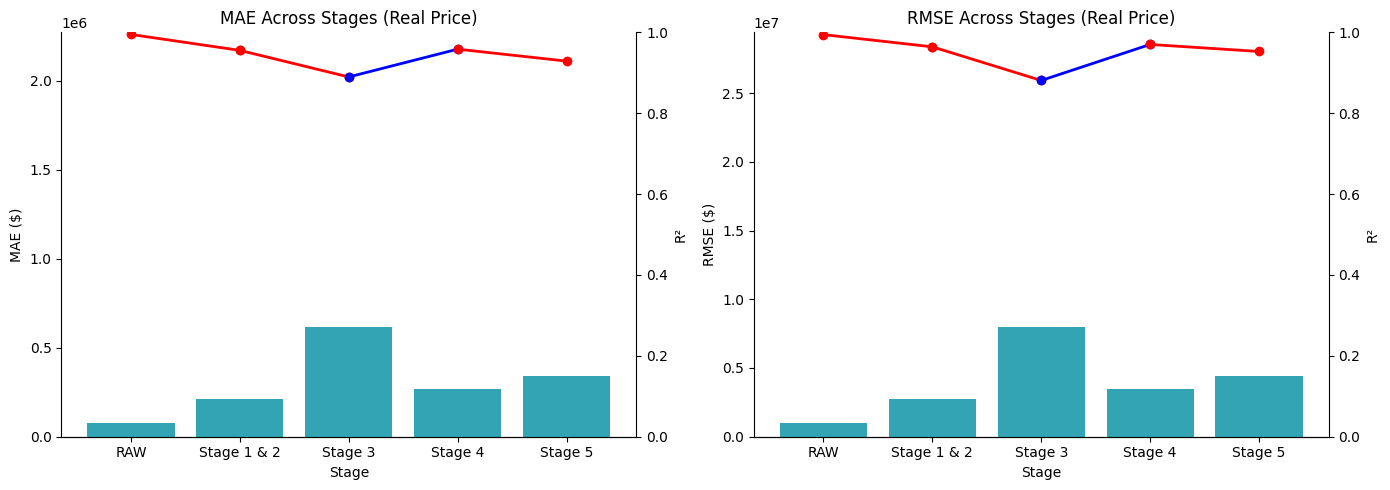

In [81]:
import matplotlib.pyplot as plt

stages = df_results["Stage"]

mae_vals  = df_results["MAE_test"].values
rmse_vals = df_results["RMSE_test"].values
r2_vals   = df_results["R2_test"].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ================== MAE + R² ==================
ax_mae = axes[0]

# Vẽ từng đoạn với màu theo xu hướng
for i in range(len(stages) - 1):
    x_seg = [stages[i], stages[i+1]]
    y_seg = [mae_vals[i], mae_vals[i+1]]
    if mae_vals[i+1] > mae_vals[i]:
        color = "blue"   # tăng
    elif mae_vals[i+1] < mae_vals[i]:
        color = "red"     # giảm
    else:
        color = "gray"
    ax_mae.plot(x_seg, y_seg, marker="o", linewidth=2, color=color)

ax_mae.set_title("MAE Across Stages (Real Price)")
ax_mae.set_xlabel("Stage")
ax_mae.set_ylabel("MAE ($)")
ax_mae.set_ylim(bottom=0)
ax_mae.grid(False)
ax_mae.spines["top"].set_visible(False)
ax_mae.spines["right"].set_visible(False)

# Trục R² bên phải (bar màu cam)
ax_mae_r2 = ax_mae.twinx()
ax_mae_r2.bar(stages, r2_vals, alpha=0.8, color="#008EA0")
ax_mae_r2.set_ylabel("R²")
ax_mae_r2.set_ylim(0, 1)
ax_mae_r2.grid(False)
ax_mae_r2.spines["top"].set_visible(False)
ax_mae_r2.spines["left"].set_visible(False)

# ================== RMSE + R² ==================
ax_rmse = axes[1]

for i in range(len(stages) - 1):
    x_seg = [stages[i], stages[i+1]]
    y_seg = [rmse_vals[i], rmse_vals[i+1]]
    if rmse_vals[i+1] > rmse_vals[i]:
        color = "blue"   # tăng
    elif rmse_vals[i+1] < rmse_vals[i]:
        color = "red"     # giảm
    else:
        color = "gray"
    ax_rmse.plot(x_seg, y_seg, marker="o", linewidth=2, color=color)

ax_rmse.set_title("RMSE Across Stages (Real Price)")
ax_rmse.set_xlabel("Stage")
ax_rmse.set_ylabel("RMSE ($)")
ax_rmse.set_ylim(bottom=0)
ax_rmse.grid(False)
ax_rmse.spines["top"].set_visible(False)
ax_rmse.spines["right"].set_visible(False)

ax_rmse_r2 = ax_rmse.twinx()
ax_rmse_r2.bar(stages, r2_vals, alpha=0.8, color="#008EA0")
ax_rmse_r2.set_ylabel("R²")
ax_rmse_r2.set_ylim(0, 1)
ax_rmse_r2.grid(False)
ax_rmse_r2.spines["top"].set_visible(False)
ax_rmse_r2.spines["left"].set_visible(False)

# Trục X chữ thẳng
for ax in axes:
    ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()